### In this notebook I will try to design yolov1 from stratch in pytorch. The code will be basic and understandable anyone who know about pytorchs nn module and basic training steps. I will be trying to comment anything that you might miss.
### You can read the original paper  <a href = 'https://arxiv.org/pdf/1506.02640.pdf'>here </a>.
### Some parts of this code taken from  <a href = 'https://www.youtube.com/watch?v=n9_XyCGr-MI'>Aladdin Persson </a> video.

In [ ]:
import torch
import torch.nn as nn

## 1. Creating the Model 
We will create the original yolov1 model from scartch so if you are not familiar with the model you can check this image.
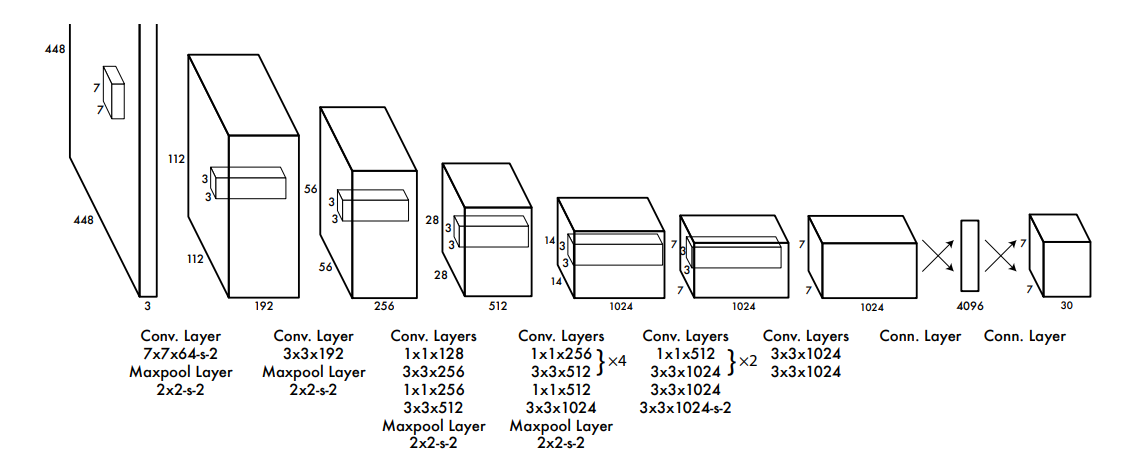

First we will define a basic CNNBlock for our architecture.We will be using leaky ReLU as activation function. We will add a batch norm to our model although original yolo didnt have but it will help training and accuracy so we will include it.

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels ,kernel_size = 3, stride =1  , padding = 1):## if groups = in_channels then this is depth_wise convolution operation
        super(CNNBlock , self).__init__()
        self.conv2d = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size , stride = stride , padding = padding , bias = False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
    def forward(self,x):
        return self.leaky_relu(self.batchnorm(self.conv2d(x)))
    
    

If you want to learn more about pytorch conv2d you check <a href = "https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">this</a> link

This picture shows how the model is doing!
And we will discuss how to remove redundant boxes later.(SPOILER: non-max supression)

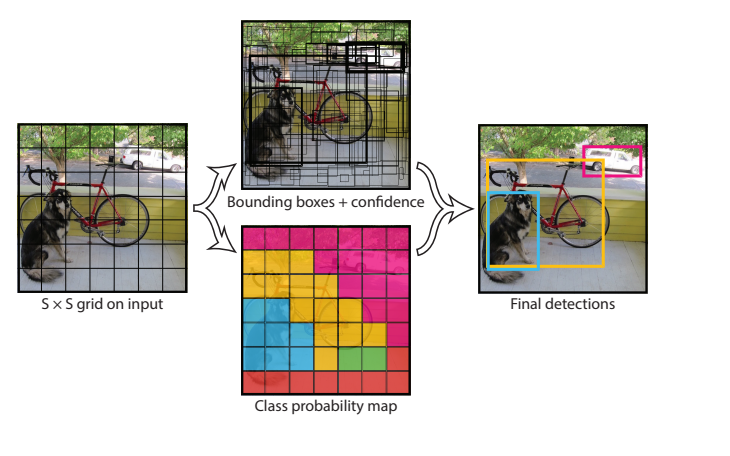


In [ ]:
class YoloV1(nn.Module):
    def __init__(self,grid_size,n_box , n_class , input_channels = 3):# S = grid_size , n_box = Bounding boxes , n_class = how many classes for classification!
        super(YoloV1 , self).__init__()
        ## This will be a long one so you can pass it if you want. Basicly creating the same model on the pic. above.
        
        self.darknet = nn.Sequential(
                     CNNBlock(in_channels = input_channels , out_channels = 64,kernel_size = 7 , stride = 2 , padding = 3),
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 64 , out_channels = 192,kernel_size = 3 , stride = 2 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 192 , out_channels = 128,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 128 , out_channels = 256,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 256 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),      
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 512 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 2 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),   
                        )
        self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear((1024*grid_size*grid_size) , 4096), #output of darknet will be S x S x 1024
                nn.Dropout(0.4),
                nn.LeakyReLU(0.1),
                nn.Linear(4096 , grid_size*grid_size*(n_class + n_box*5)) # there will be n_class + n_box*5 outputs for each grid (we multiplt n_box with  5 because each box contains; midpoint_x , midpoint_y , width , height ,confidence  )
                )
        
    def forward(self,x):
        x = self.darknet(x)
        return self.fc(x)
        
        
        

In [ ]:
## Test the model for S = 7 , Box = 2 , Classes = 20 

# Expected output shape [2,1470] where 1470 is 7 x 7  x (5 x 2 + 20)

#model = YoloV1(7,2,20)
#x = torch.randn((2,3,448,448))
#print(model(x).shape)

## Utility Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [ ]:
def IOU(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [ ]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [ ]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [ ]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## 2. Defining the Loss function

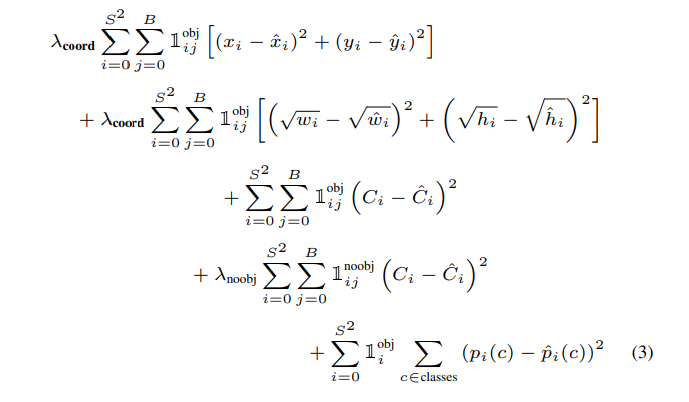

What we have here is a bit long loss function but we can understand it by diving it into smaller pieces.

In the first line we see the loss for midpoints. Lets just ignore lambda values for now (Lambda_coord , Lambda_noobj). 
We see a basic mse loss with the indicator function in front of it. In simple words it says; sum up all the distances between the target and prediction midpoints for all grids iff grid i contains an object and bounding box j is "responsible" for outputing that object. Now here responsible means that the bounding box with the highest IOU(intersection over union) score with the target box. So which means we ignore the grid i that does not contain an object and also the bounding boxes that are not responsible. In this way we just penalize the model for the distance for true labels. 

In the second line everyhing is the same except now we calculate the distances for width and height. The reason we use sqrt here is we dont want to penalize the model for the difference of w and h for large objects. And the rest is the same for indcator and bounding boxes.

In the third line we calculate the confidance score loss which means if there was an object at grid i and responsible bounding box had a confidence score for that object, how bad our prediction is? And we still just calculate it for responsible bounding boxes and True labeled grids.


The fourth part that is the inverse of part 3 we calculate the same thing for no object at grid i and the responsible bounding box j.

And lastly, we calculate the differences of probabilities of class predictions and ground truth labels if the grid i contains an object. 


The lamdas here helps us to modify the loss we set Lambda_noobj to 0.5 and Lambda_coord to 5 here what we do is, we are pushing the model for better bounding box predictions and we give some room to model for wrong object predictions.

In [ ]:
class LossFunction(nn.Module):
    def __init__(self , grid_size = 7 ,n_box = 2 , n_class = 20,lambda_coord = 5, lambda_noobj = 0.5):
        super(LossFunction,self).__init__()
        self.mse = nn.MSELoss(reduction = "sum")
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.n_grid = grid_size
        self.n_box = n_box
        self.n_class = n_class
        
    def forward(self,preds , target):
        """
         
            C: Confidience that there is an object
            X , Y , W , H: (X , Y) midpoints of an object and (W, H) is the width and the height 
            cn: object Class n lower c means class probability. 
         
         
            1 grid prediction [C1 X1 Y1 W1 H1 C2 X2 Y2 W2 H2 c1 c2 c3 ... c(n_class)] we constrain the grids so that each grid can only contain 1 object
            1 grid Target [C X Y W H c1 c2 c3 ... c(n_class)]
            Target.shape = [N , S , S , (5 + c)]
            preds.shape =  [N, S , S ,(c + 5*B)]
        """    
            
        
        predictions = preds.reshape(-1,self.n_grid , self.n_grid ,(5 * self.n_box + self.n_class)) ## [1 , 1470] -> [N, S , S ,(C + 5*B)]
       
            
        iou1 = IOU(predictions[... , 1:5] , target[... , 1:5])
        iou2 = IOU(predictions[... , 6:10] , target[... , 1:5])
        
        ious = torch.cat([iou1.unsqueeze(0), iou2.unsqueeze(0)], dim=0) # [2 , N , S , S]
        
        iou_maxes, bestbox = torch.max(ious, dim=0) # bestbox  = [0 1 0 0 1 1 1 0 0 ... 0 0 1 0 ...] shape is [N , S , S , 1] each index represents which bounding box to choose
        
        
        
        # This gives us if there is an object at grid i for every sample in the batch
        exists_box = target[..., 0].unsqueeze(3) # shape [N ,S , S, 1] we put a dummy dimension to match the dimensions of predictions
        
        
        
        ## box_predictions.shape = [N, S , S ,4] - > [X Y W H]
        box_predictions = exists_box * ( ## If there is an object we calculate which bounding box had the highest IOU and we take it
            (
                bestbox * predictions[..., 6:10] # [N , S , S, 1] * [ N , S , S , 4]
                + (1 - bestbox) * predictions[..., 1:5]
            )
        ) # we have predicted x , y , w ,h 
        
        ## Calculate the target boxes
        box_target = exists_box * target[... , 1:5] ## box_target.shape = [N, S , S ,4] - > [X Y W H]
        
        
        
        ## We take the sqrt of W H for preds and targets
        
        """
         We take the sign of the prediction to preserve the distance, absolute value to prevent error ( sqrt(negative_value) ) and 1e-6 for 
         numeric stability because derivative(sqrt(0)) is discontinuous.
         
        """
        
        
        box_preds = torch.sign(box_predictions[... , 2:4])*torch.sqrt(torch.abs(box_predictions[... , 2:4] + 1e-6)) 
        
        box_target = box_target[... , 2:4]*torch.sqrt(box_target[... , 2:4])
        
        
        
        
        
        ## Now let calculate the loss for boxes which will cover the first two lines of the loss function
        
        box_loss = self.mse(
            torch.flatten(box_preds, end_dim = -2),## output shape is [N*S*S , 4], what we do is we calculate the distances of 4 elements for each batch sample and grid
            torch.flatten(box_target, end_dim = -2)
        )
        
        
        
        ## Now the third row of the loss function
        
        
        obj_box_conf = exists_box *(# Calculating the same thing with boxes for Object confidience
            bestbox * predictions[..., 5:6] + (1 - bestbox) * predictions[..., 0:1]
        ) # confidence for Highest IOU boxes if there is an object
        
        object_loss = self.mse(## Shape [N*S*S , 1] 
            torch.flatten(obj_box_conf, end_dim=-2),
            torch.flatten(exists_box * target[..., 0:1], end_dim=-2),
        )
        
        
        
        
        ## Now the fourth row of the loss function
        
        bbox_j = (1 - exists_box)*(
            bestbox * predictions[... , 4:5] + (1-bestbox)*predictions[... , 0:1]
        )
        
        
        no_object_loss = self.mse(## Shape [N*S*S , 1] 
            torch.flatten(bbox_j,end_dim=-2),
            torch.flatten((1 - exists_box) * target[..., 0:1], end_dim=-2),
        )

        
        # And lastly , class probability loss
        
        class_loss = self.mse(## Shape [N*S*S , n_class] 
            torch.flatten(exists_box * predictions[..., 10:], end_dim=-2),
            torch.flatten(exists_box * target[..., 5:], end_dim=-2,),
        )
        
        ## Now we implement lamdas and here is our final loss 
        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss
        

## Dataset

In [ ]:
import glob
label_path = glob.glob("../input/pascalvoc-yolo/labels/*.txt") 
img_path = glob.glob("../input/pascalvoc-yolo/images/*.jpg") 
    
print("# text data is: ",len(label_path) , "# Images: ",len(img_path))    

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
from io import open
import glob
import torch
import os

class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self
    ):
       #                                               X  Y  x y w h c
      ## We need to outpu a label matrix whcich is = [S ,S, 5 + c] 
        label_path = glob.glob("../input/pascalvoc-yolo/labels/*.txt") 
    
        self.datadict = {}
        index_allocator = []
        a = 1/7
        restriction = 0 ## load 500 images
        for filename in label_path:
            file_number = os.path.splitext(os.path.basename(filename))[0]
            lines = open(filename).read().replace("\n", " ")
            l = [
                float(x) if float(x) != int(float(x)) else int(x)
                for x in lines.split()
            ]
            index_allocator.append(file_number)
            labels = np.zeros((7,7,25))
            l = np.array(l).reshape(-1,5) ## Class x y w h
            for i in l:
                x_grid = i[1]/a
                y_grid = i[2]/a
                
                one_hot = np.zeros((20))
                one_hot[int(i[0])] = 1
                labels[int(x_grid),int(y_grid)] = np.concatenate( ( np.array([1 ,(i[1] % 1),(i[2]%1) , i[3] , i[4]]) , one_hot ) ,axis = 0)
            self.datadict[len(index_allocator)-1] = [labels]    
            if restriction == 500:
                break
            restriction += 1 
            
           
            
            
        
            
        for img_name in index_allocator:
            img_path = "../input/pascalvoc-yolo/images/"+img_name+".jpg"
            
            img = Image.open(img_path)
            
            self.datadict[index_allocator.index(img_name)].append(img.resize((448,448)))
           
                
        del index_allocator
        
    def __len__(self):
        return len(self.datadict)
    
    
    def __getitem__(self, index):
        
        return torch.tensor(np.array(self.datadict[index][1])).permute(2,0,1).to(torch.float) , torch.tensor(self.datadict[index][0])
        
        
       
  

In [ ]:
## Testing the dataset
custom_dataset = VOCDataset()

In [ ]:
'''
    from matplotlib.pyplot import imshow
    import numpy as np
    from PIL import Image

    %matplotlib inline
    pil_im = custom_dataset.__getitem__(100)[1]
    imshow(np.asarray(pil_im))
    '''

In [ ]:
custom_dataset.__len__()

## Training and evaluation

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader


model = YoloV1(7,2,20)


loss =  LossFunction()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

optimizer = optim.Adam(
        model.parameters(), lr=2e-5, weight_decay=0
    )

dataloader = DataLoader(dataset = custom_dataset , batch_size = 32  , shuffle = True )

loop = tqdm(dataloader, leave=True)

model.to(device)
model.train()
epochs = 20
optimizer.zero_grad()
losses = 0
loss_list = []
for i in range(epochs):
    
    for batch_index ,(inp , target) in enumerate(loop):
        optimizer.zero_grad()
        inp = inp.to(device)
        target = target.to(device)
            
        out = model(inp)
        
        #print("Target shape is: ",target.shape)
        #print("output size is: ", out.shape)
        losses = loss(out , target)
        loss_list.append(losses.item())
        
        losses.backward()
        optimizer.step()
        loop.set_postfix(loss = losses.item())
        del inp
        del target
        del out
    print(f"Mean loss was {sum(loss_list)/len(loss_list)}")   
        

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

In [ ]:
x = len(loss_list)/(300)
clear = []
for i in range(50):
    clear.append(loss_list[int(i*x)])

In [ ]:
plt.figure()
plt.plot(clear)